In [7]:
print(np.arange(1e-5, 1+1e-5, 1e-5))

[1.0000e-05 2.0000e-05 3.0000e-05 ... 9.9998e-01 9.9999e-01 1.0000e+00]


In [8]:
import sys
import os
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch

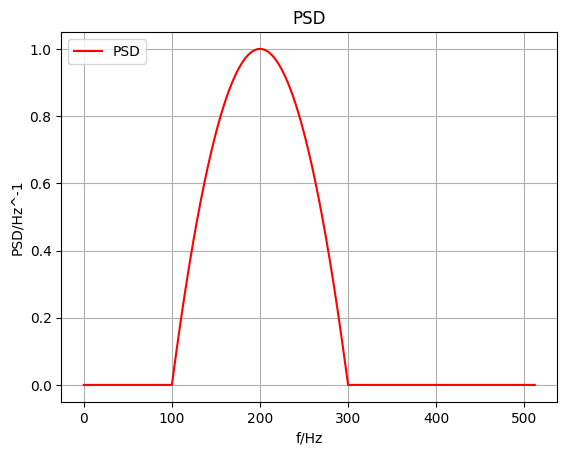

In [9]:
samp_freq=2
n_samp=16384
time_vec=1/samp_freq*np.arange(0,n_samp,1)
def targetPSD(f):
    out=np.zeros(len(f))
    for i in range(0,len(f)):
        if (100 <= f[i]) and (f[i]<= 300):
            out[i]=(f[i] - 100) * (300 - f[i]) / 10000
        else:
            out[i]=0
    return out
freq=np.arange(0,512.1,0.1)
PSD=targetPSD(freq)
plt.plot(freq,PSD,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()


In [10]:
import numpy as np

def fftfilt(b, x):
    """Use FFT to apply FIR filter defined by b to signal x."""
    # 获取输入信号和滤波器的长度
    N_x = len(x)
    N_b = len(b)
    
    # 计算 FFT 的大小
    N = N_x + N_b - 1
    
    # 计算滤波器和输入信号的 FFT
    X = np.fft.fft(x, N)
    B = np.fft.fft(b, N)
    
    # 乘以滤波器的频率响应
    Y = X * B
    
    # 计算逆 FFT 以获得滤波后的信号
    y = np.fft.ifft(Y)
    
    # 取出中间的部分，与输入信号长度相同
    start = (N_b - 1) // 2
    y = y[start:start + N_x]
    
    # 只取实部（虚部应该非常接近零）
    return np.real(y)

# 示例
b = np.random.randn(500)
x = np.random.randn(16384)
y = fftfilt(b, x)

print(len(y))  # 输出应为 16384


16384


In [11]:
def stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq):
    sqrt_PSD=np.sqrt(PSD)
    sqrt_PSD[-1]=0
    #b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    b=firwin2(flt_ord,freq/(samp_freq/2),sqrt_PSD)
    in_noise=np.random.randn(1,n_samp)
    # print(in_noise.shape,b.shape)
    # print(fftfilt(b,in_noise[0]).shape)
    return np.sqrt(samp_freq)*fftfilt(b,in_noise[0])


In [12]:
flt_ord=500
out_noise=stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq)
f,Px=welch(out_noise,samp_freq,'hann',256)
f=f.reshape(1,-1)
#print(f.shape,Px.shape)

plt.plot(f[0],Px,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()

#print(out_noise.shape)
plt.plot(time_vec,out_noise,'r',label="stat_gauss_noise")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("noise")
plt.legend(loc='upper left')
plt.title("stat_gauss_noise")
plt.show()

ValueError: freq must start with 0 and end with fs/2.

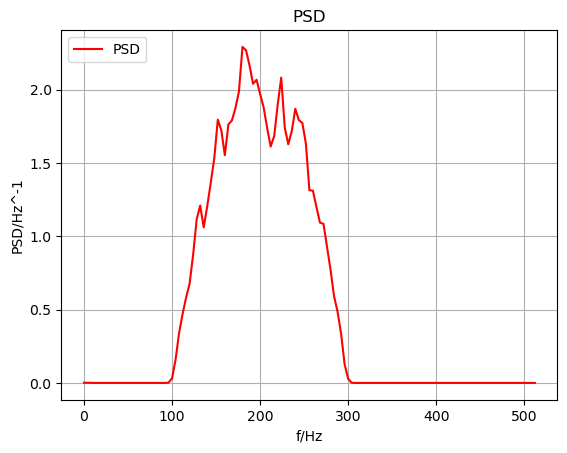

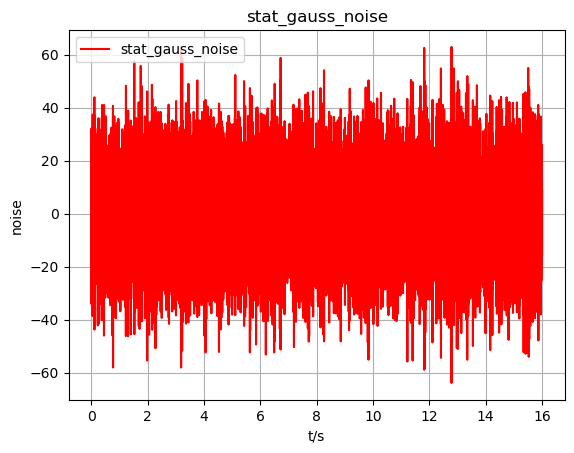

In [6]:
flt_ord=500
out_noise=stat_gauss_noise(n_samp,freq,PSD,flt_ord,samp_freq)
f,Px=welch(out_noise,samp_freq,'hann',256)
f=f.reshape(1,-1)
#print(f.shape,Px.shape)

plt.plot(f[0],Px,'r',label="PSD")
plt.grid(True)
plt.xlabel("f/Hz")
plt.ylabel("PSD/Hz^-1")
plt.legend(loc='upper left')
plt.title("PSD")
plt.show()

#print(out_noise.shape)
plt.plot(time_vec,out_noise,'r',label="stat_gauss_noise")
plt.grid(True)
plt.xlabel("t/s")
plt.ylabel("noise")
plt.legend(loc='upper left')
plt.title("stat_gauss_noise")
plt.show()

In [13]:
import numpy as np 
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

def generate_noise_from_psd(N, freqVec,psd, num_noises=1,freq_range=[-1,999], sample_rate = 4096, duration = None):
    #freqVec = np.linspace(0, sample_rate/2, len(psd))
    noises = np.zeros((num_noises, N))
    interpolated_asds = []
    for i in range(num_noises):
        WGN = np.random.randn(N)
        X = np.fft.rfft(WGN) / np.sqrt(N)
        asd = np.sqrt(psd)
        uneven = N % 2
        # Simulate the white noise of rFFT
        # X = (np.random.randn(N // 2 + 1 + uneven) + 1j * np.random.randn(N // 2 + 1 + uneven))
        
        selected_indices = np.where((freqVec >= freq_range[0]) & (freqVec <= freq_range[1]))[0]
        #print(selected_indices)
        # Interpolate selected ASD values to match the length of X
        interp_asd = interp1d(freqVec[selected_indices],asd[selected_indices], kind='linear', bounds_error=False, fill_value="extrapolate")
        newFreqVec = np.fft.rfftfreq(N+uneven, d=1.0/sample_rate)
        #print(newFreqVec)
        interpolated_asd = interp_asd(newFreqVec)
        nonSelected_indices = np.where(~ ((newFreqVec> freq_range[0]) & (newFreqVec < freq_range[1])))[0]
        interpolated_asd[nonSelected_indices] = 1e-30
        # interpolated_asd[interpolated_asd<1e-30] = 1e-30

        # Apply the random ASD to create colored noise
        # In order to keep the nSample equal to before
        Y_colored = X * interpolated_asd
        y_colored = np.fft.irfft(Y_colored).real * np.sqrt(N*sample_rate)
        if uneven:
            y_colored = y_colored[:-1]
        
        noises[i, :] = y_colored 
        interpolated_asds.append(interpolated_asd)
        #print(noises)
        
    return noises, interpolated_asds


In [14]:
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD

200000
[[-5.22014577e-17 -5.22018759e-17 -5.21967984e-17 ...
  -5.22035529e-17 -5.22125396e-17 -5.21991243e-17]]


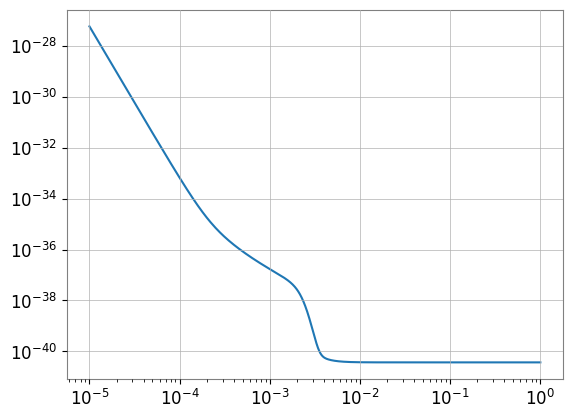

In [15]:
freq=np.arange(1e-5,1+1e-5,1e-5)
N=round(2/1e-5)
print(N)
noise,_=generate_noise_from_psd(N,freq,PSD_Lisa_no_Response(freq)/2,sample_rate=2)
time=1/2*np.arange(0,N)
print(noise)
plt.loglog(freq,PSD_Lisa_no_Response(freq))

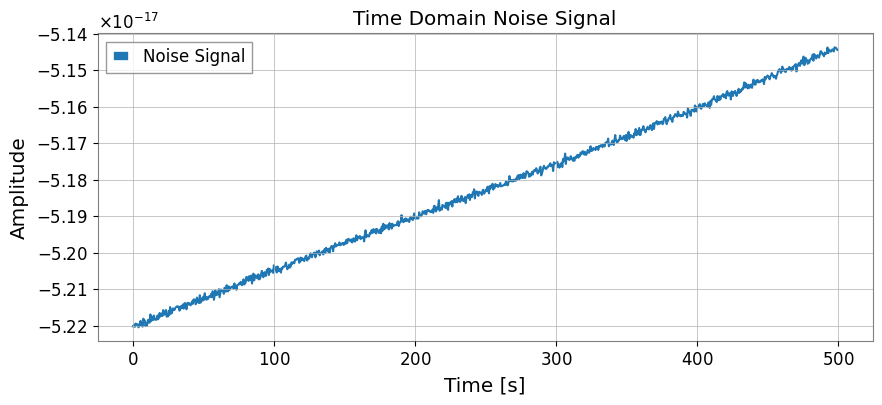

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 4))

plt.plot(time[:1000], noise[0][:1000], label='Noise Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()
plt.grid(True)
plt.show()

[0.0078125 0.015625  0.0234375 0.03125   0.0390625 0.046875
 0.0546875 0.0625    0.0703125 0.078125  0.0859375 0.09375
 0.1015625 0.109375  0.1171875 0.125     0.1328125 0.140625
 0.1484375 0.15625   0.1640625 0.171875  0.1796875 0.1875
 0.1953125 0.203125  0.2109375 0.21875   0.2265625 0.234375
 0.2421875 0.25      0.2578125 0.265625  0.2734375 0.28125
 0.2890625 0.296875  0.3046875 0.3125    0.3203125 0.328125
 0.3359375 0.34375   0.3515625 0.359375  0.3671875 0.375
 0.3828125 0.390625  0.3984375 0.40625   0.4140625 0.421875
 0.4296875 0.4375    0.4453125 0.453125  0.4609375 0.46875
 0.4765625 0.484375  0.4921875 0.5       0.5078125 0.515625
 0.5234375 0.53125   0.5390625 0.546875  0.5546875 0.5625
 0.5703125 0.578125  0.5859375 0.59375   0.6015625 0.609375
 0.6171875 0.625     0.6328125 0.640625  0.6484375 0.65625
 0.6640625 0.671875  0.6796875 0.6875    0.6953125 0.703125
 0.7109375 0.71875   0.7265625 0.734375  0.7421875 0.75
 0.7578125 0.765625  0.7734375 0.78125   0.7890625 0.79

/tmp/ipykernel_15055/3584627658.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1e-39)


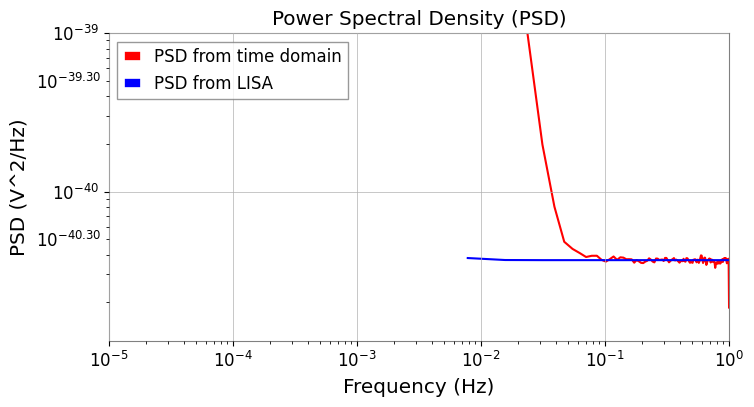

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# 示例序列（可以替换成你自己的序列）
signal = np.random.randn(1024)  # 生成一个随机信号作为示例

# 定义采样率
fs = 1000  # 示例采样率为 1000 Hz

# 使用 Welch 方法计算 PSD
frequencies, psd = welch(noise[0], 2, nperseg=256)

# 打印频率和 PSD 值
print(frequencies[1:])
print(psd[1:])
print(PSD_Lisa_no_Response(frequencies[1:]))
# 可视化 PSD
plt.figure(figsize=(8, 4))
plt.loglog(frequencies[1:],psd[1:],'-r',label='PSD from time domain')

plt.loglog(frequencies[1:],PSD_Lisa_no_Response(frequencies[1:]),'-b',label='PSD from LISA')
plt.xlim(1e-5,1)
plt.ylim(0,1e-39)
plt.legend()
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.grid(True)
plt.show()


In [18]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD


/tmp/ipykernel_15055/2174002029.py:13: RuntimeWarning: divide by zero encountered in divide
  Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
/tmp/ipykernel_15055/2174002029.py:14: RuntimeWarning: divide by zero encountered in divide
  Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
/tmp/ipykernel_15055/2174002029.py:15: RuntimeWarning: divide by zero encountered in power
  Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \


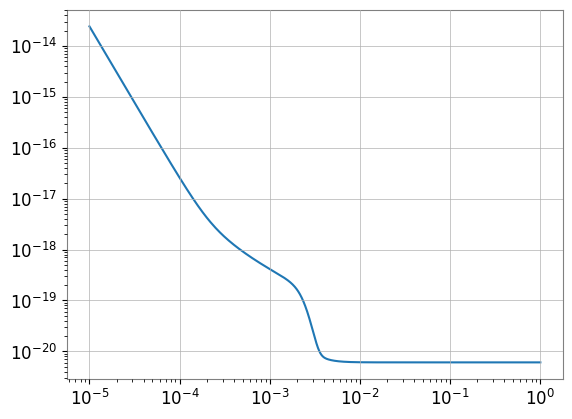

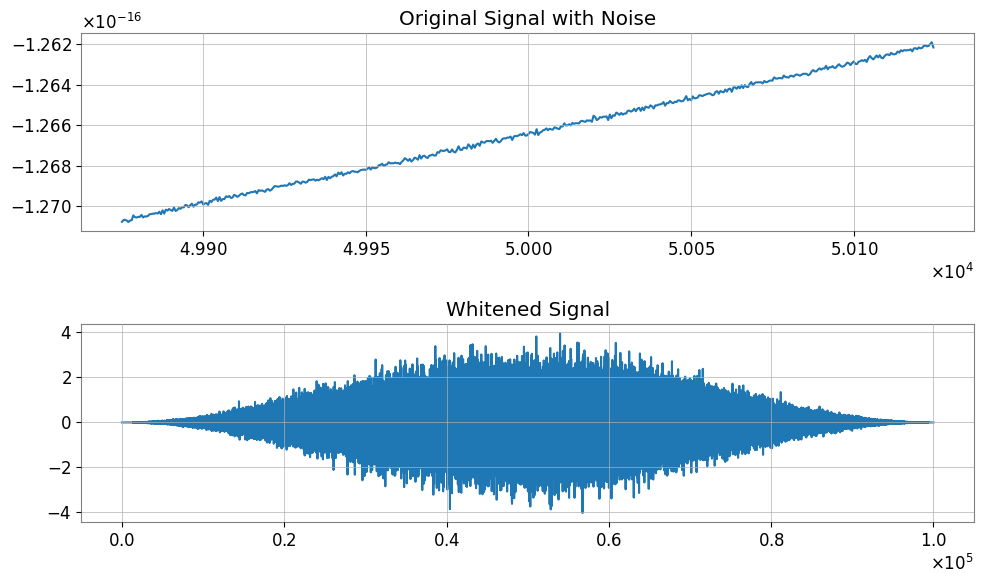

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据（带噪声的正弦波）
length=500
start=int(1/2*(len(time)-length))
# 白化处理
whitened_signal,freqs,asd = whiten(noise[0], sample_rate=2,psd=PSD_Lisa_no_Response,highpass=2e-3)
plt.loglog(freqs,asd)
#plt.loglog(freqs,np.sqrt(PSD_Lisa_no_Response(freqs)))
# 可视化原始和白化后的信号
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time[start:start+length], noise[0][start:start+length])
plt.title('Original Signal with Noise')
plt.subplot(2, 1, 2)
plt.plot(time, whitened_signal)
plt.title('Whitened Signal')
plt.tight_layout()
plt.show()


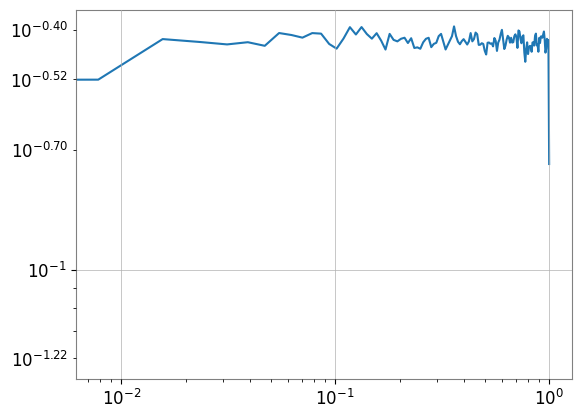

In [20]:
frequencies, psd = welch(whitened_signal, 2, nperseg=256)
plt.loglog(frequencies,psd)

In [3]:
import numpy as np
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from config.config import Config
from waveform import *
from ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import fftfilt, stat_gauss_noise,generate_noise_from_psd
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
import os
# def rotate_list(lst, position=2):
#     index = len(lst) // position
#     return lst[index:] + lst[:index]
SAVE_PATH_1= 'data/signal_data.npz'
SAVE_PATH_2 = 'data/signal_test_data.npz'
SAVE_PATH_noise= 'data/signal_data_with_noise.npz'
TEMP_DIR_1 = 'data/temp_files'
TEMP_DIR_2 = 'data/temp_files2'
os.makedirs(TEMP_DIR_1, exist_ok=True)  # 创建临时文件目录
scale=Config.scale
samp_freq=Config.samp_freq


Noises=True
def generate_single_data(i):
    # 生成单个数据的代码
    Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
    M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
    R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
    signal_length = Config.signal_length

    para = [Mtot, M_ratio, R_shift]
    freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
    f_sf = sf(freq_ifft, para, para_dw, para_dtau)
    st = Ga.Freq_ifft(f_sf)#*Config.zoom_factor

    if Noises:
        
        index = int(1/2*len(st))
        st=np.concatenate((st[index:], st[:index]))
        PSD=PSD_Lisa_no_Response(freq_ifft)
        out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
        
        #print(len(out_noise[0]))
        start1=int(1/2*(len(out_noise[0])-signal_length))
        start2=int(1/2*(len(st)-signal_length))
        #print(len(out_noise[0][start:start+signal_length]))
        signal = st[start2:start2+signal_length]
        signal=torch.tensor(signal)
        signal=torch.real(signal)
        
        noise=out_noise[0][start1:start1+signal_length]
        noise=torch.tensor(noise)
        noise=torch.real(noise)

        data=signal+noise
        return signal,noise,data, torch.tensor([Mtot, M_ratio, R_shift], dtype=torch.float32)

    else:
        original_signal = st[:signal_length]
        original_signal = torch.tensor(original_signal, dtype=torch.float32)
        original_signal = torch.real(original_signal)
        return original_signal, torch.tensor([Mtot, M_ratio, R_shift], dtype=torch.float32)

200000
199996 99999 99999
199996
199996
[0.00000e+00 5.00000e-01 1.00000e+00 ... 9.99965e+04 9.99970e+04
 9.99975e+04]


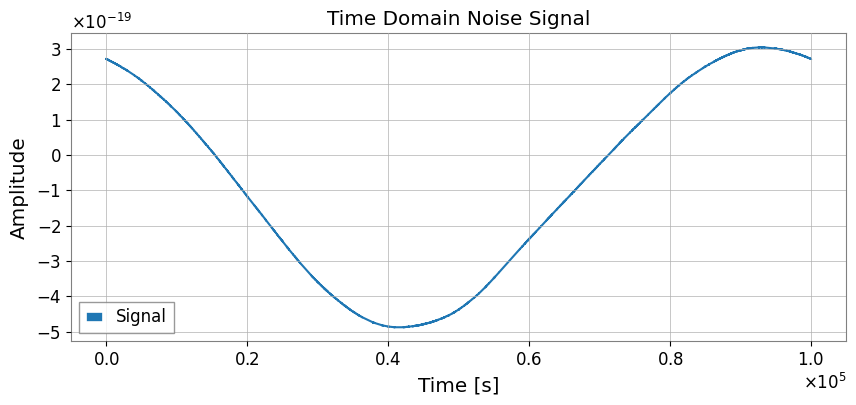

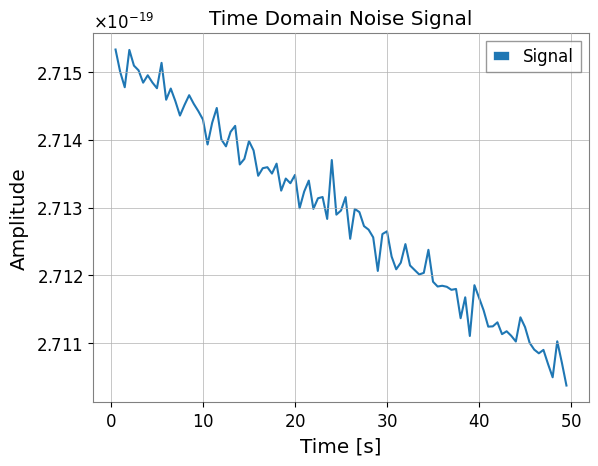

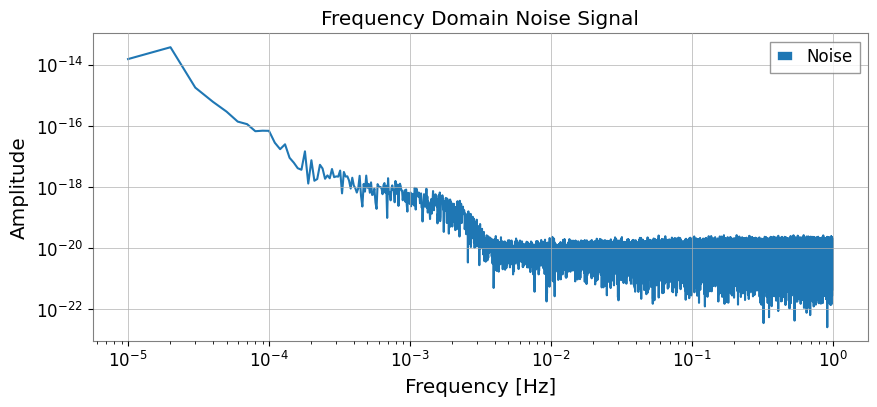

In [13]:
Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
signal_length = Config.signal_length
N=round(samp_freq/Config.f_step)
print(N)
para = [Mtot, M_ratio, R_shift]
freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
f_sf = sf(freq_ifft, para, para_dw, para_dtau)
st = Ga.Freq_ifft(f_sf)*Config.zoom_factor
print(len(st),len(freq_ifft),len(f_sf))
PSD=PSD_Lisa_no_Response(freq_ifft)
out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
print(len(out_noise[0]))
dt = 1.0 / samp_freq  # 采样时间间隔
time_array = np.linspace(0, (len(st) - 1) * dt, len(st))
print(len(time_array))
print(time_array)
#绘制噪声曲线
plt.figure(figsize=(10, 4))
#plt.plot(time_array, out_noise[0], label='Noise Signal')
plt.plot(time_array, out_noise[0], label='Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()   
plt.grid(True)
plt.show()
plt.plot(time_array[1:100],out_noise[0][1:100], label='Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()   
plt.grid(True)
plt.show()

noise_f=np.fft.rfft(out_noise[0])
#用loglog图绘制频域噪声
plt.figure(figsize=(10, 4))
plt.loglog(freq_ifft,np.abs(noise_f), label='Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Noise Signal')
plt.legend()
plt.grid(True)
plt.show()



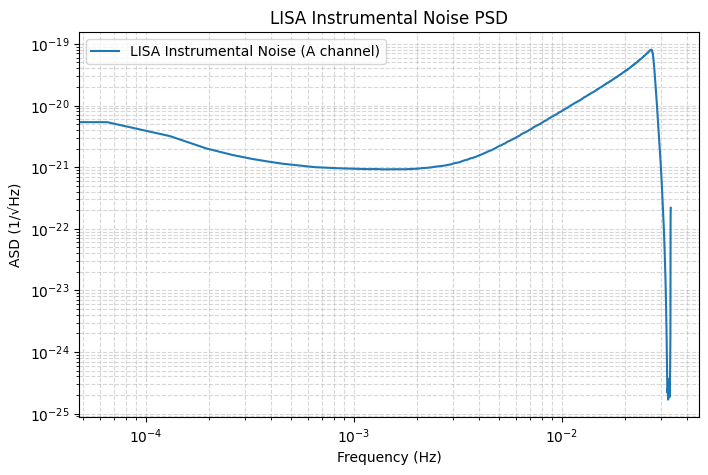

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py

# Load LISA noise data
LISA_noise_data = h5py.File("/home/ljq/code/Ringdown_gap_filling/Proj/data/LISA_noise.mat", 'r')

# Extract noise data
nX = np.array(LISA_noise_data['nXVec'][:]).flatten()
nY = np.array(LISA_noise_data['nYVec'][:]).flatten()
nZ = np.array(LISA_noise_data['nZVec'][:]).flatten()

# Convert XYZ to A channel (simplified XYZ2AET function)
noise_A = (nZ - nX)/np.sqrt(2)

# Get sampling frequency
dt = 15  # assuming 15 seconds based on standard LISA data
fs = 1/dt

# Calculate PSD using Welch method
f_noise, psd_noise_A = signal.welch(noise_A, fs, nperseg=2**10)
#print(psd_noise_A)
# Plot the noise PSD
plt.figure(figsize=(8, 5))
plt.loglog(f_noise, np.sqrt(psd_noise_A), label='LISA Instrumental Noise (A channel)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (1/√Hz)')
plt.title('LISA Instrumental Noise PSD')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


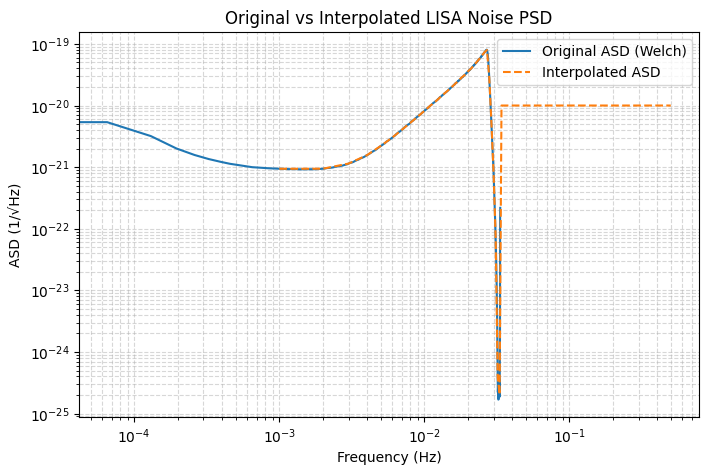

In [9]:
from scipy.interpolate import interp1d

# 自定义频率数组
freq = np.arange(0.001, 0.5, 0.001)

# 构建 PSD 插值函数（外推时自动填充极小值）
psd_interp_func = interp1d(f_noise, psd_noise_A,
                           kind='linear',
                           bounds_error=False,
                           fill_value=1e-40)

# 得到目标频率数组上的 PSD
psd_interpolated = psd_interp_func(freq)
plt.figure(figsize=(8, 5))
plt.loglog(f_noise, np.sqrt(psd_noise_A), label='Original ASD (Welch)')
plt.loglog(freq, np.sqrt(psd_interpolated), '--', label='Interpolated ASD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD (1/√Hz)')
plt.title('Original vs Interpolated LISA Noise PSD')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()


199996 99999 99999
199996
199996
[0.00000e+00 5.00000e-01 1.00000e+00 ... 9.99965e+04 9.99970e+04
 9.99975e+04]


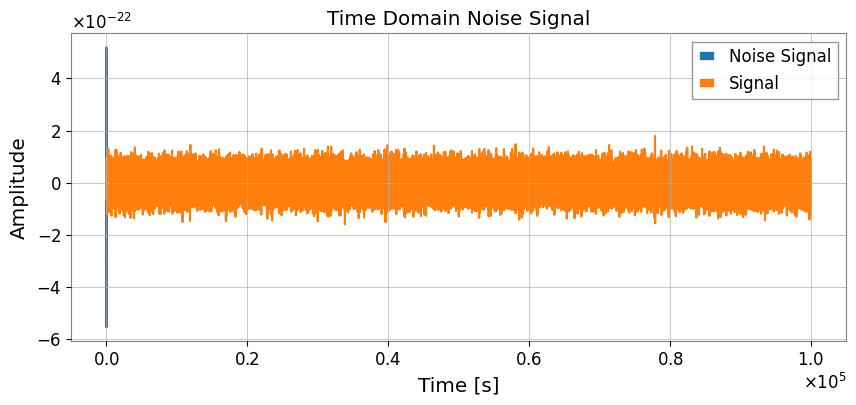

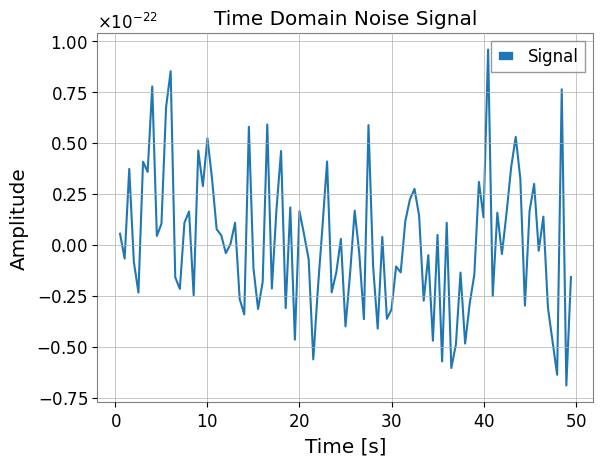

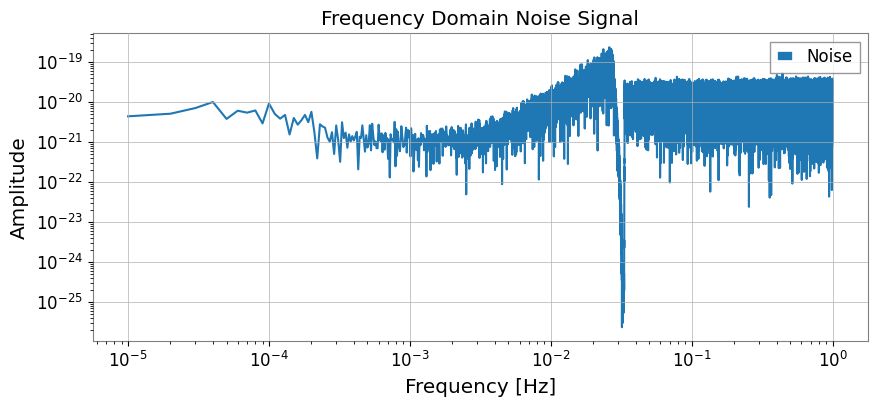

In [ ]:
import numpy as np
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from config.config import Config
from waveform import *
from ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import fftfilt, stat_gauss_noise,generate_noise_from_psd
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
import os
# def rotate_list(lst, position=2):
#     index = len(lst) // position
#     return lst[index:] + lst[:index]
SAVE_PATH_1= 'data/signal_data.npz'
SAVE_PATH_2 = 'data/signal_test_data.npz'
SAVE_PATH_noise= 'data/signal_data_with_noise.npz'
TEMP_DIR_1 = 'data/temp_files'
TEMP_DIR_2 = 'data/temp_files2'
os.makedirs(TEMP_DIR_1, exist_ok=True)  # 创建临时文件目录
scale=Config.scale
samp_freq=Config.samp_freq
Mtot = np.random.uniform(Config.parameters[0], Config.parameters[1])
M_ratio = np.random.uniform(Config.parameters[2], Config.parameters[3])
R_shift = np.random.uniform(Config.parameters[4], Config.parameters[5])
signal_length = Config.signal_length


para = [Mtot, M_ratio, R_shift]
freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
f_sf = sf(freq_ifft, para, para_dw, para_dtau)
st = Ga.Freq_ifft(f_sf)*Config.zoom_factor
print(len(st),len(freq_ifft),len(f_sf))
PSD=psd_interp_func(freq_ifft)
out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
print(len(out_noise[0]))
dt = 1.0 / samp_freq  # 采样时间间隔
time_array = np.linspace(0, (len(st) - 1) * dt, len(st))
print(len(time_array))
print(time_array)
#绘制噪声曲线
plt.figure(figsize=(10, 4))
plt.plot(time_array, st, label='Noise Signal')
plt.plot(time_array, out_noise[0], label='Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()   
plt.grid(True)
plt.show()
plt.plot(time_array[1:100],out_noise[0][1:100], label='Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Noise Signal')
plt.legend()   
plt.grid(True)
plt.show()

noise_f=np.fft.rfft(out_noise[0])
#用loglog图绘制频域噪声
plt.figure(figsize=(10, 4))
plt.loglog(freq_ifft,np.abs(noise_f), label='Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Noise Signal')
plt.legend()
plt.grid(True)
plt.show()



2999


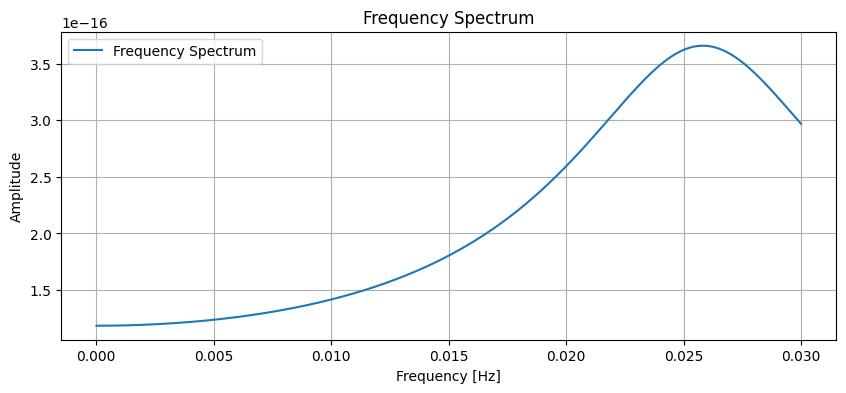

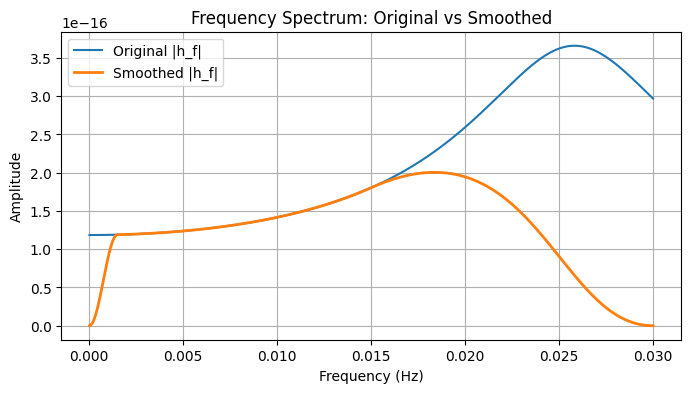

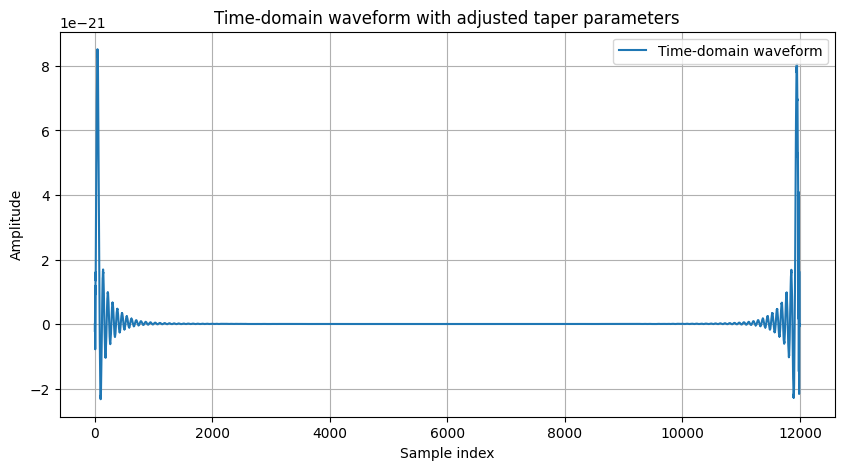

In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from waveform_GR.rd_wf import *
from math import pi
fs=1/15
freq=np.arange(0.00001,0.03,0.00001)
h = model(6.5, 0.2, 1, 2/9, 0, pi/3, freq) 
# np.savetxt('h.txt', h)
# np.savetxt('f.txt', freq)
print(len(h))

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import firwin
from scipy.fft import ifft, ifftshift
from scipy.signal import butter, filtfilt
from scipy.signal.windows import tukey
# Load data6
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from data.IMR import *
# f= np.loadtxt("f.txt")
# h=np.loadtxt("h.txt",dtype=complex)
h_f=h
#绘制频谱图
plt.figure(figsize=(10, 4))
plt.plot(freq, np.abs(h_f), label='Frequency Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.legend()
plt.grid(True)
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# ------------------------ 假设已有输入 ------------------------
# 假设你已有仅包含正频谱数据的复数数组 h_f 和对应的频率数组 freq（单位Hz）
# 例如：
# N_orig = 1000
# freq = np.linspace(0, 50, N_orig)         # 示例：0~50 Hz
# h_f = np.random.randn(N_orig) + 1j*np.random.randn(N_orig)
# 请替换下面代码中的 h_f, freq 为你真实的数据

# ------------------------ 1. 平滑频谱截断 ------------------------
# 此处我们同时对低频和高频两端进行平滑处理，减小边界不连续性引入的瞬态

# --- 低频平滑 ---
# 如果你的频谱在 f=0 附近存在突变，可以对低频部分做渐入处理。
# 例如，设定从 f_low_taper_start 到 f_low_taper_end 渐入从 0 到 1。
# 如果不需要低频平滑，可以把 f_low_taper_start=0, f_low_taper_end=0，即不改变窗函数（这里示例进行低频平滑）
f_low_taper_start = 0.0           # 低频起始处（通常设为 0）
f_low_taper_end = 0.05 * freq[-1]  # 低频结束处，举例取最高频的5%（根据频谱范围调节）

# --- 高频平滑 ---
# 将高频部分从 f_high_taper_start 到 f_high_taper_end 渐出，使得高频平滑降至零
f_high_taper_start = 0.5 * freq[-1]  # 举例：从最高频的50%处开始衰减
f_high_taper_end   = freq[-1]        # 高频截止处（必须使得 f_high_taper_end 与 freq[-1] 相等）

# 构造窗函数 W：初始值全1，之后在低频和高频区域修改
W = np.ones_like(freq)

# 低频渐入窗：在 f_low_taper_start 到 f_low_taper_end 之间使用余弦窗从0上升到1
if f_low_taper_end > f_low_taper_start:
    mask_low = (freq >= f_low_taper_start) & (freq < f_low_taper_end)
    # 余弦窗公式：W = 0.5*(1 - cos(pi*(f - f_low_taper_start)/(f_low_taper_end - f_low_taper_start)))
    W[mask_low] = 0.5 * (1 - np.cos(np.pi * (freq[mask_low] - f_low_taper_start) / (f_low_taper_end - f_low_taper_start)))
    # 低于 f_low_taper_start 时，窗值设为0
    W[freq < f_low_taper_start] = 0.0

# 高频渐出窗：在 f_high_taper_start 到 f_high_taper_end 之间使用余弦窗从1降到0
mask_high = (freq >= f_high_taper_start) & (freq <= f_high_taper_end)
W[mask_high] = 0.5 * (1 + np.cos(np.pi * (freq[mask_high] - f_high_taper_start) / (f_high_taper_end - f_high_taper_start)))
# 高频大于 f_high_taper_end 处，窗值设为0
W[freq > f_high_taper_end] = 0.0

# 将窗函数应用到原始正频谱上
h_f_smoothed = h_f * W

# 可选：绘制原始和平滑后的频谱幅值比较
plt.figure(figsize=(8, 4))
plt.plot(freq, np.abs(h_f), label='Original |h_f|')
plt.plot(freq, np.abs(h_f_smoothed), label='Smoothed |h_f|', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum: Original vs Smoothed')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------ 2. 零填充 ------------------------
# 为了提高时域分辨率和延长时域信号，使瞬态的影响在更长信号上被稀释，
# 对正频谱进行零填充，这里定义一个零填充因子 pad_factor
pad_factor = 2  # 例如2倍延长，可以调大，比如 4 或 8，看效果
N_pos = len(h_f_smoothed)  # 原正频谱点数
# 对于实时域信号，完整频谱的正频谱部分长度应满足：N_pos_new = pad_factor*(N_pos-1)+1
N_pos_new = pad_factor * (N_pos - 1) + 1
zero_pad_length = N_pos_new - N_pos
# 在频谱末尾追加零
h_f_padded = np.concatenate([h_f_smoothed, np.zeros(zero_pad_length, dtype=complex)])

# ------------------------ 3. 构造共轭对称频谱 ------------------------
# 要生成实值时域波形，需要构造完整的共轭对称频谱。对于正频谱长度 N_pos_new，
# 对应完整频谱长度 N_total = 2*(N_pos_new - 1)
N_total = 2 * (N_pos_new - 1)
# 负频部分为正频谱中去掉直流和奈奎斯特分量的部分取共轭后倒序得到
H_neg = h_f_padded[1:-1].conjugate()[::-1]
# 拼接完整频谱：正频谱（已零填充） + 负频共轭部分
H_full = np.concatenate([h_f_padded, H_neg])

# ------------------------ 4. 逆傅里叶变换得到时域波形 ------------------------
# 对完整频谱 H_full 进行逆 FFT 得到时域信号，理论上结果应为实值
h_time = np.fft.ifft(H_full)
h_time = np.real(h_time)  # 取实部，舍去数值误差引入的虚部
alpha=0.1
tukey_win = signal.windows.tukey(len(h_time), alpha=alpha)

h_time_windowed = h_time * tukey_win
# ------------------------ 5. 绘制时域波形 ------------------------
plt.figure(figsize=(10, 5))
plt.plot(h_time_windowed, label='Time-domain waveform')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform with adjusted taper parameters')
plt.grid(True)
plt.legend()
plt.show()

# ------------------------ 参数调试说明 ------------------------
# 如果在得到的时域波形中瞬态（transient）仍然明显，你可以尝试调整以下参数：
# 1. 调整 f_low_taper_start 和 f_low_taper_end：
#    - 如果低频端存在不连续性，可设定 f_low_taper_start 稍大于 0，让低频部分平滑上升。
# 2. 调整 f_high_taper_start 和 f_high_taper_end：
#    - 将 f_high_taper_start 值降低（例如从 0.5*freq[-1] 改为 0.3*freq[-1]），使衰减区更宽，
#      可让高频部分有更平缓的过渡，从而减小由高频截断产生的时域振铃。
# 3. 增大 pad_factor：
#    - 增大零填充因子，如从 2 提升到 4 或 8，可以拉长时域波形，使瞬态振铃分布在更长的时间上，从而降低局部峰值。


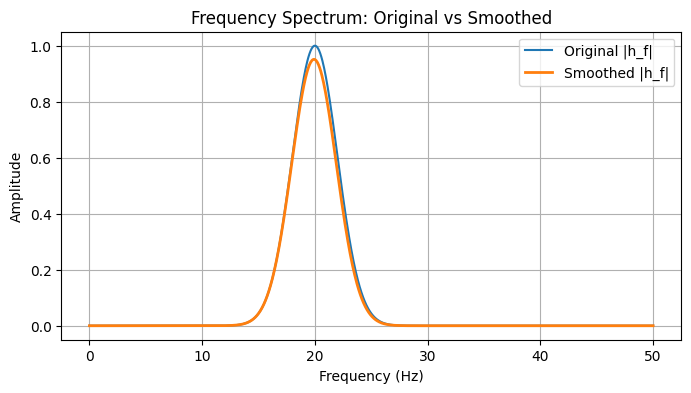

3996


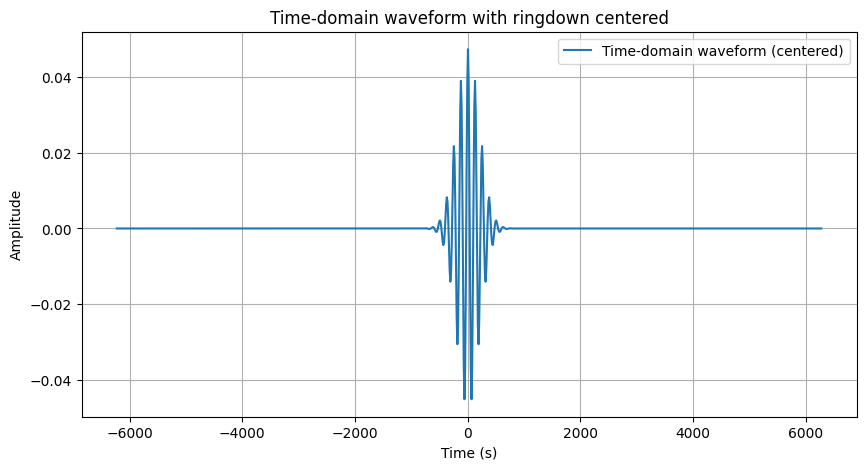

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
fs=1/15
freq=np.arange(0.00001,0.03,0.00001)
h = model(6.5, 0.2, 1, 2/9, 0, pi/3, freq) 

# ------------------------ 示例：构造输入数据 ------------------------
# 以下部分仅为示例，真实应用时请替换为你实际的频谱数据
# 设定频率范围：例如0到50 Hz，共1000个点
N_orig = 1000
freq = np.linspace(0, 50, N_orig)  # 频率数组，单位 Hz

# 模拟一个 ringdown 频谱信号：在某个中心频率附近（例如20 Hz）存在一个峰，
# 幅值采用高斯形状，初始相位为0。
f0 = 20.0       # 中心频率
width = 2.0     # 峰宽
h_f = np.exp(-((freq - f0)**2)/(2*width**2)) * np.exp(1j*0)  # 仅正频谱（复数数据）

# ------------------------ 1. 平滑频域截断 ------------------------
# 为防止频谱在两端硬截断引起不连续，在低频与高频端分别采用余弦窗做平滑过渡。

# 设置低频平滑参数（这里假设低频端也需要平滑，避免 DC 或极低频 abrupt 开启）
f_low_taper_start = 0.0                    # 从 0 Hz 开始
f_low_taper_end   = 0.01 * freq[-1]         # 例如取最高频的1%，本例中 freq[-1] = 50 Hz，所以 f_low_taper_end = 0.5 Hz

# 设置高频平滑参数
# 若你希望高频部分平滑衰减，使得 ringdown 部分集中，建议扩大高频渐出区间
f_high_taper_start = 0.3 * freq[-1]         # 例如从 15 Hz 开始
f_high_taper_end   = freq[-1]               # 截止频率 50 Hz

# 构造窗函数 W：初始全为1
W = np.ones_like(freq)

# 低频渐入窗：在 f_low_taper_start 到 f_low_taper_end 内余弦窗从 0 上升到 1
mask_low = (freq >= f_low_taper_start) & (freq < f_low_taper_end)
W[mask_low] = 0.5 * (1 - np.cos(np.pi * (freq[mask_low] - f_low_taper_start) / (f_low_taper_end - f_low_taper_start)))
W[freq < f_low_taper_start] = 0.0  # f < f_low_taper_start 设为0

# 高频渐出窗：在 f_high_taper_start 到 f_high_taper_end 内余弦窗从 1 降到 0
mask_high = (freq >= f_high_taper_start) & (freq <= f_high_taper_end)
W[mask_high] = 0.5 * (1 + np.cos(np.pi * (freq[mask_high] - f_high_taper_start) / (f_high_taper_end - f_high_taper_start)))
W[freq > f_high_taper_end] = 0.0  # f > 截止频率处设为0

# 将窗函数应用到输入频谱上
h_f_smoothed = h_f * W

# 绘制原始与平滑后的频谱（取幅值对比）
plt.figure(figsize=(8,4))
plt.plot(freq, np.abs(h_f), label='Original |h_f|')
plt.plot(freq, np.abs(h_f_smoothed), label='Smoothed |h_f|', linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum: Original vs Smoothed')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------ 2. 零填充 ------------------------
# 为了延长时域长度、提高分辨率并稀释瞬态效果，对平滑后的正频谱进行零填充。
pad_factor = 2  # 零填充因子，可调大（如4、8）以降低瞬态峰值
N_pos = len(h_f_smoothed)  # 原正频谱点数
# 满足实值时域信号要求：完整正频谱长度应为 N_pos_new = pad_factor*(N_pos - 1) + 1
N_pos_new = pad_factor * (N_pos - 1) + 1
zero_pad_length = N_pos_new - N_pos
h_f_padded = np.concatenate([h_f_smoothed, np.zeros(zero_pad_length, dtype=complex)])

# ------------------------ 3. 构造共轭对称频谱 ------------------------
# 对于实值时域信号，完整频谱必须满足共轭对称性。已填充后的正频谱长度为 N_pos_new，
# 则完整频谱长度为 N_total = 2*(N_pos_new - 1)
N_total = 2 * (N_pos_new - 1)
# 构造负频谱：取正频谱（去除直流和奈奎斯特分量）的共轭并倒序排列
H_neg = h_f_padded[1:-1].conjugate()[::-1]
# 拼接得到完整频谱
H_full = np.concatenate([h_f_padded, H_neg])

# ------------------------ 4. 逆傅里叶变换得到时域波形 ------------------------
# 设定时域总长度 T（单位秒），此 T 应与频率分辨率 df=1/T 互为倒数
T = 50000.0  # 可根据实际需求选择时域长度
# 注意：由于我们经过零填充后的完整频谱长度为 N_total，
# 时间域采样间隔 dt = T / N_total
dt = T / N_total

# 计算时域信号
h_time = np.fft.ifft(H_full)
h_time = np.real(h_time)  # 取实部

# ------------------------ 5. 将时域信号中心对齐 ------------------------
# 默认的 IFFT 输出时域信号时间起点是 t=0，对应数组索引0，
# 但若希望信号的 ringdown 部分（或主要振荡）位于时间序列中心，
# 可对时域信号作 FFT移位，使得 t=0 位于数组正中。
h_time_shifted = np.fft.fftshift(h_time)
# 同时构造一个对称的时间轴，范围从 -T/2 到 T/2
time_axis = np.linspace(-T/2, T/2, len(h_time_shifted))
print(len(h_time_shifted))
# ------------------------ 6. 绘制时域波形 ------------------------
plt.figure(figsize=(10, 5))
plt.plot(time_axis[1500:2500], h_time_shifted[1500:2500], label='Time-domain waveform (centered)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform with ringdown centered')
plt.legend()
plt.grid(True)
plt.show()


t shape: (1000,)
hp1 shape: (1000,)
hst shape: (1000,)


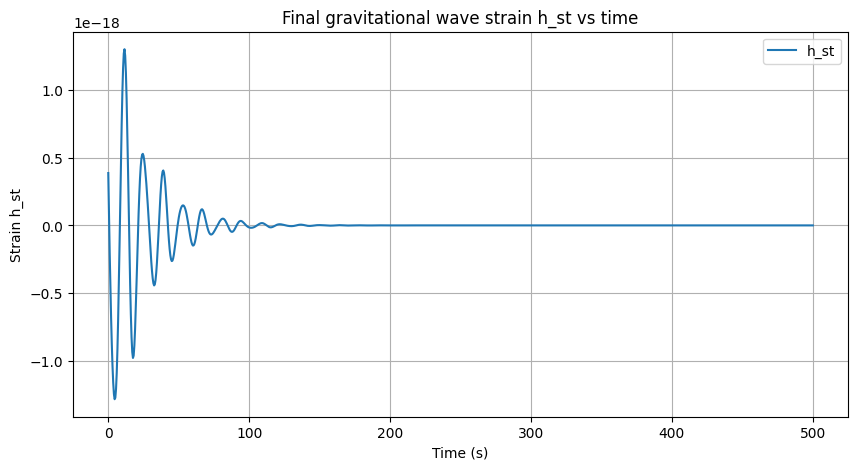

In [63]:
import numpy as np
import matplotlib.pyplot as plt
Ms = 1.99*10**30
pc = 3.26*9.46*10**15
c = 3.0e8  
cG = 6.67430e-11 

M = 3e5*Ms          # 基础质量 [kg]
dM =0                 
                    # 光速 [m/s]
r = 0.5e9*pc               # 距离 [m]
dr = 0  
a=0.9               # 自旋参数
v=2/9               #对称质量比             
mode_matrix = np.array([
    [0.6000, -0.2339, 0.4175, -0.3000, 2.3561, -0.2277],
    [1.5251, -1.1568, 0.1292,  0.7000, 1.4187, -0.4990],
    [1.8956, -1.3043, 0.1818,  0.9000, 2.3430, -0.4810],
    [2.3000, -1.5056, 0.2244,  1.1929, 3.1191, -0.4825],
])
def A1(v):
    return 0.864*v

def  A3(v):
    return 0.44*(1 - 4*v)**0.45*A1(v)
# 对应模态标签
modes = [(2, 1), (2, 2), (3, 3), (4, 4)]
pc = 3.26*9.46*10**15
Ms = 1.99*10**30
c = 3*10**8
cG = 6.67*10**-11
# 封装返回关于 M, chi 的 QNM 函数
def get_qnm_functions(mode_matrix, modes):
    """
    为每个模式生成一个返回 ω_GR 和 τ_GR 的函数，保存在字典中
    """
    qnm_functions = {}

    for i, (l, m) in enumerate(modes):
        f1, f2, f3, q1, q2, q3 = mode_matrix[i]

        def qnm_func(M, chi, f1=f1, f2=f2, f3=f3, q1=q1, q2=q2, q3=q3):
            omega = (f1 + f2 * (1 - chi)**f3) / (M)/cG*c**3
            tau = 2 * (q1 + q2 * (1 - chi)**q3) / omega
            return omega, tau

        qnm_functions[(l, m)] = qnm_func

    return qnm_functions

# 生成 QNM 函数字典
qnm_dict = get_qnm_functions(mode_matrix, modes)

# 示例：计算 (3,3) 模式在 M=100, chi=0.8 下的 QNM 频率与衰减时间
#omega_33, tau_33 = qnm_dict[(3, 3)](M=6, chi=0.8)
def w22(m,a):
    return qnm_dict[(2, 2)](m,a)[0]
def w33(m,a):
    return qnm_dict[(3, 3)](m,a)[0]
def tau22(m,a):
    return qnm_dict[(2, 2)](m,a)[1]
def tau33(m,a):
    return qnm_dict[(3, 3)](m,a)[1]


phi = 0.5                 # φ（弧度）

# ----------------------------
# 模式参数：对两个模式(1)和(3)
# ----------------------------
# 振幅因子 A
A = {1: A1(v), 3: A3(v)}
# 阻尼时间常数 τ
tau = {1: tau22(M,a), 3: tau33(M,a)}
# 角频率 w（单位：rad/s），例如各模式的频率
w = {1: w22(M,a), 3: w33(M,a)}
# 模式指数 m
m = {1: 2, 3: 3}

# ----------------------------
# 球谐函数部分，对应 Yp 和 Yc
# 这里 x 为一个标量（角度，单位：弧度），通常由物理模型或观测给出
# ----------------------------
x = np.pi/3  # 弧度
Yp = {}
Yc = {}
Yp[1] = np.sqrt(5/(4*np.pi)) * (1 + np.cos(x)**2) / 2.0
Yp[3] = - np.sqrt(21/(8*np.pi)) * (1 + np.cos(x)**2) / 2.0 * np.sin(x)
Yc[1] = np.sqrt(5/(4*np.pi)) * np.cos(x)
Yc[3] = - np.sqrt(21/(8*np.pi)) * np.cos(x) * np.sin(x)

# ----------------------------
# 计算模式 (1) 和 (3) 对应的 h₊ 和 hₓ 分量，使用 numpy 的向量化计算
# ----------------------------
# 公共前置因子（注意所有模式共享此因子）
prefactor = cG * (M * (1 + dM)) / (c**2 * r * (1 + dr))

# ----------------------------
# 时间参数，t为序列输入
# ----------------------------
t0 = 0.                 # 参考时间 [s]
T = 500.0                 # 总时长 [s]
num_points = 1000         # 时间序列点数
t = np.linspace(t0, t0 + T, num_points)  # t为 numpy 数组
# 模式 (1)：
hp1 = prefactor * A[1] * np.exp(-(t - t0)/tau[1]) * Yp[1] * np.cos(w[1]*(t - t0) - m[1]*phi)
hc1 = -prefactor * A[1] * np.exp(-(t - t0)/tau[1]) * Yc[1] * np.sin(w[1]*(t - t0) - m[1]*phi)

# 模式 (3)：
hp3 = prefactor * A[3] * np.exp(-(t - t0)/tau[3]) * Yp[3] * np.cos(w[3]*(t - t0) - m[3]*phi)
hc3 = -prefactor * A[3] * np.exp(-(t - t0)/tau[3]) * Yc[3] * np.sin(w[3]*(t - t0) - m[3]*phi)

# 假设总的 h₊ 和 hₓ 分量为各模式的线性叠加
hpt = hp1 + hp3  # plus 极
hct = hc1 + hc3  # cross 极

# ----------------------------
# 计算天线图样因子，并合成最终时域信号 h_st
# 公式：
#   h_st = h_pt * [0.5*(1+cos²θ)*cos(2ψ)*cos(2φ₀) - cosθ*sin(2ψ)*sin(2φ₀)]
#        + h_ct * [0.5*(1+cos²θ)*sin(2ψ)*cos(2φ₀) + cosθ*cos(2ψ)*sin(2φ₀)]
# 注意：θ, ψ, φ₀ 均为常数（弧度），φ₀ 这里表示源的极化角，不是初相位。
# ----------------------------
theta =0  # 观察方位角 θ
psi = np.pi/3    # 偏振角 ψ
phi0 = np.pi    # 极化角 φ₀

antenna_plus = 0.5*(1 + np.cos(theta)**2)*np.cos(2*psi)*np.cos(2*phi0) - np.cos(theta)*np.sin(2*psi)*np.sin(2*phi0)
antenna_cross = 0.5*(1 + np.cos(theta)**2)*np.sin(2*psi)*np.cos(2*phi0) + np.cos(theta)*np.cos(2*psi)*np.sin(2*phi0)

hst = hpt * antenna_plus + hct * antenna_cross

# ----------------------------
# 输出并绘图
# ----------------------------
print("t shape:", t.shape)
print("hp1 shape:", hp1.shape)
print("hst shape:", hst.shape)

plt.figure(figsize=(10, 5))
plt.plot(t, hst, label='h_st')
plt.xlabel('Time (s)')
plt.ylabel('Strain h_st')
plt.title('Final gravitational wave strain h_st vs time')
plt.legend()
plt.grid(True)
plt.show()


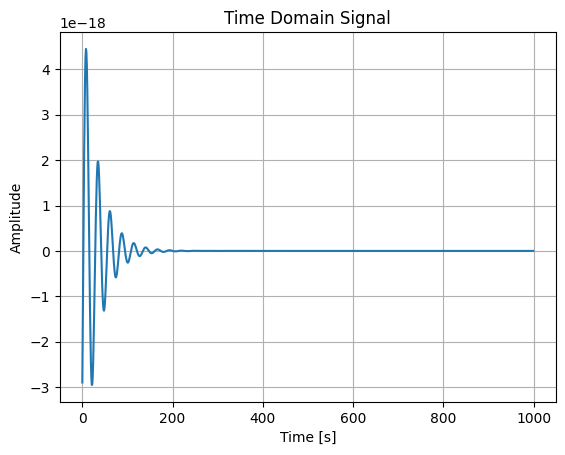

In [14]:
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from data.waveform_GR.rd_wf_t import *
import matplotlib.pyplot as plt
dt=1
time=np.arange(0, 1000)*dt
h=hst(time,5e5,0.5,0.8,2/9)
plt.plot(time,h)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.grid(True)
plt.show()


19831
19831
39660
39660


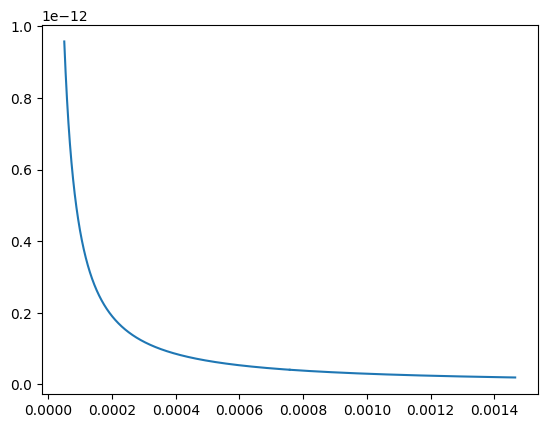

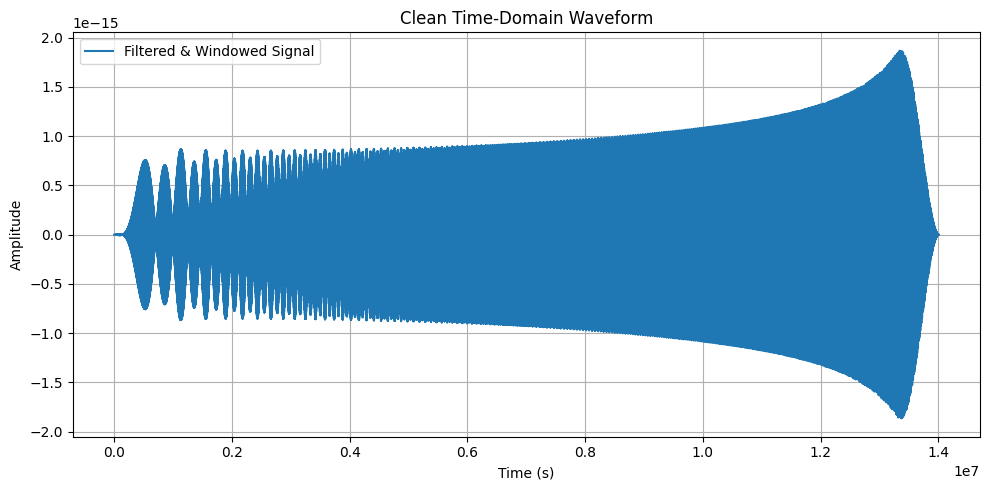

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin
from scipy.fft import ifft, ifftshift
from scipy.signal import butter, filtfilt
from scipy.signal.windows import tukey
# Load data6
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from data.IMR import *
# f= np.loadtxt("f.txt")
# h=np.loadtxt("h.txt",dtype=complex)
f,h=h_model(1,1e6,2e6,5e-5)
#保存成npz文件
np.savez("data.npz",f=f,h=h)
N_target = 100000
f = f[:N_target]
h = h[:N_target]
print(len(h))
print(len(f))
#Construct full spectrum(Hermitian symmetry)
h_neg =np.conj(h[1:-1][::-1])
h_full =np.concatenate([h, h_neg])

 #Sampling parameters
N=len(h_full)
print(N)
df=f[1]-f[0]
fs = df*N
dt=1/fs
time =np.arange(N)/ fs

plt.plot(f, np.abs(h))
h_time = ifft(ifftshift(h_full))

# Design a high-pass Butterworth filter
cutoff_freq = 0.0001  # Hz
nyquist = fs / 2
normal_cutoff = cutoff_freq / nyquist
b, a = butter(N=4, Wn=normal_cutoff, btype='high', analog=False)

# Apply high-pass filter
h_filtered = filtfilt(b, a, np.real(h_time))

# # Apply a Tukey window to reduce transient effects
window = tukey(N, alpha=0.1)
#h_clean = h_filtered * window
h_clean = h_filtered * window
print(len(h_clean))
# Plot the final time-domain signal
plt.figure(figsize=(10, 5))
plt.plot(time, h_clean, label='Filtered & Windowed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Clean Time-Domain Waveform')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



19831
79320


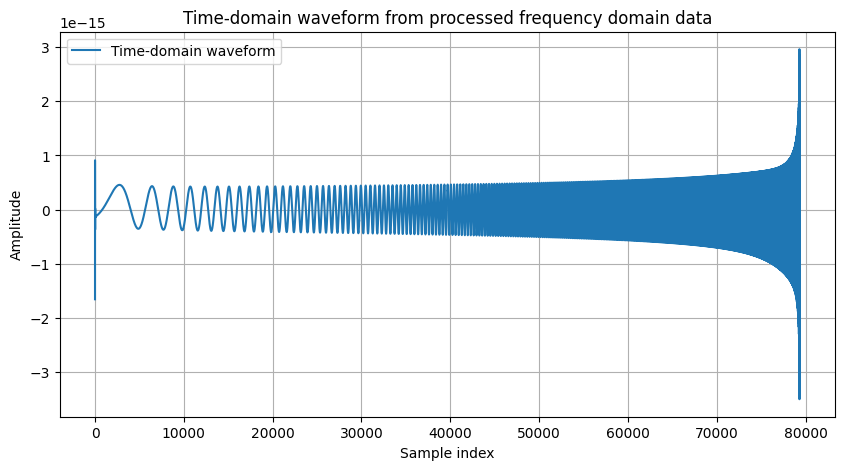

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin
from scipy.fft import ifft, ifftshift
from scipy.signal import butter, filtfilt
from scipy.signal.windows import tukey
# Load data6
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
from data.IMR import *
# f= np.loadtxt("f.txt")
# h=np.loadtxt("h.txt",dtype=complex)
freq,h_f=h_model(1,1e6,2e6,5e-5)
print(len(h_f))
#保存成npz文件
# ------------------------ 假设已有的正频谱数据 ------------------------
# h_f: 复数数组，代表正频率范围内的频谱数据（包括 DC 分量和最高频分量）
# freq: 与 h_f 对应的频率数组，单位 Hz，递增排列
# 下面示例中，我们假设 h_f 和 freq 已由其它程序生成，这里只做处理示例。
# 请确保 h_f 和 freq 的长度一致。

# 例如（注：这只是示例数据，请替换成你自己的数据）：
# N_orig = 1000
# freq = np.linspace(0, 50, N_orig)  # 频率从 0 Hz 到 50 Hz
# h_f = np.random.randn(N_orig) + 1j*np.random.randn(N_orig)

# ------------------------ 1. 平滑频域截断 ------------------------
# 为减少频谱在高频端的硬截断导致的时域振铃，我们对频谱施加一个余弦窗。
# 设定平滑截止起始频率和截止频率（一般取正频谱中最后一段，即高频部分）
f_taper_start = 0.8 * freq[-1]  # 从最高频的 80% 开始平滑
f_taper_end   = freq[-1]        # 最高频处窗函数值应为 0

# 构造窗函数: 当 f < f_taper_start 时窗函数值为 1；在 [f_taper_start, f_taper_end] 内由 1 平滑过渡到 0
W = np.ones_like(freq)
mask = (freq >= f_taper_start) & (freq <= f_taper_end)
# 余弦窗公式：W = 0.5*(1 + cos(pi*(f - f_taper_start)/(f_taper_end - f_taper_start)))
W[mask] = 0.5 * (1 + np.cos(np.pi * (freq[mask] - f_taper_start) / (f_taper_end - f_taper_start)))
# 对于 freq > f_taper_end（通常最高点），W 设为 0
W[freq > f_taper_end] = 0.0

# 将窗函数应用到频谱数据上
h_f_smoothed = h_f * W

# ------------------------ 2. 零填充 ------------------------
# 为提高时域分辨率（或延长时域信号长度），我们对正频谱进行零填充。
# 设定零填充因子 pad_factor（例如 2 表示扩展到原来的两倍正频谱长度）。
pad_factor = 2
# 原正频谱点数 (包含 DC 和最高频分量)
N_pos = len(h_f_smoothed)
# 对于实值时域信号，FFT 结果（全谱）应满足：正频谱长度 = N_total/2 + 1，其中 N_total 为时域采样点数
# 因此，新的正频谱长度为：
N_pos_new = pad_factor * (N_pos - 1) + 1
# 需要填充的零数目：
zero_pad_length = N_pos_new - N_pos
# 在频谱末尾追加零（注意数据类型为复数）
h_f_padded = np.concatenate([h_f_smoothed, np.zeros(zero_pad_length, dtype=complex)])

# ------------------------ 3. 构造共轭对称频谱 ------------------------
# 对于实值时域信号，其 FFT 必须满足共轭对称：H[-k] = conjugate(H[k])
# 已有的正频谱（经过 zero padding）的长度为 N_pos_new，对应的全谱长度应为：
N_total = 2 * (N_pos_new - 1)
#
# 构造负频部分：取正频谱中除 DC 和奈奎斯特分量外（即 h_f_padded[1:-1]）的共轭倒序
H_neg = h_f_padded[1:-1].conjugate()[::-1]
# 合并正负频谱，构成完整的频谱
H_full = np.concatenate([h_f_padded, H_neg])

# ------------------------ 4. 逆傅里叶变换得到时域波形 ------------------------
# 对完整频谱进行逆 FFT，得到时域信号
h_time = np.fft.ifft(H_full)
# 理论上结果应为实数，由于数值误差可取实部
h_time = np.real(h_time)
print(len(h_time))
# ------------------------ 5. 绘制结果 ------------------------
plt.figure(figsize=(10, 5))
plt.plot(h_time, label='Time-domain waveform')
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('Time-domain waveform from processed frequency domain data')
plt.grid(True)
plt.legend()
plt.show()


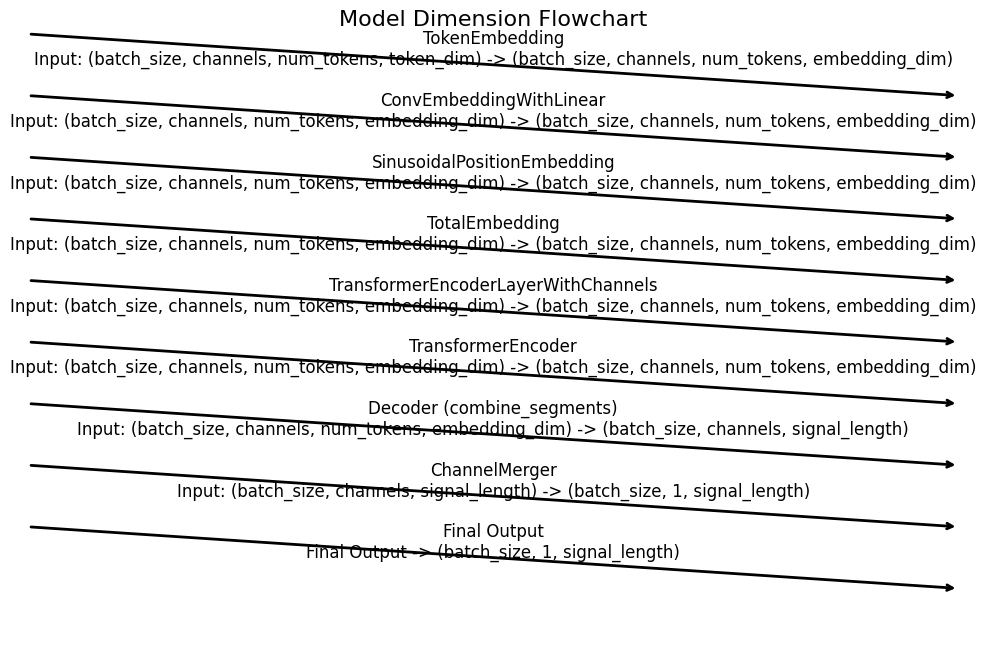

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Initialize a plot
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the transformations for each step
# Define the transformations (from -> to) in the format (start, end, description)
transforms = [
    ('Input: (batch_size, channels, num_tokens, token_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'TokenEmbedding'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'ConvEmbeddingWithLinear'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'SinusoidalPositionEmbedding'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'TotalEmbedding'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'TransformerEncoderLayerWithChannels'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, num_tokens, embedding_dim)', 'TransformerEncoder'),
    ('Input: (batch_size, channels, num_tokens, embedding_dim)', '(batch_size, channels, signal_length)', 'Decoder (combine_segments)'),
    ('Input: (batch_size, channels, signal_length)', '(batch_size, 1, signal_length)', 'ChannelMerger'),
    ('Final Output', '(batch_size, 1, signal_length)', 'Final Output'),
]

# Plot each transformation with arrows
for i, (start, end, label) in enumerate(transforms):
    ax.annotate('', xy=(1, 1 - (i+1)*0.1), xytext=(0, 1 - i*0.1), arrowprops=dict(arrowstyle='->', lw=2))
    ax.text(0.5, 1 - (i+0.5)*0.1, f'{label}\n{start} -> {end}', horizontalalignment='center', fontsize=12)

# Remove axes
ax.set_axis_off()

# Set plot title
ax.set_title('Model Dimension Flowchart', fontsize=16)

# Display the flowchart
plt.show()


In [33]:
#这里是将频域的信号，通过一个小trick逆傅里叶变换到纯实的时域波形
def Freq_ifft(h_f_1):
    Htilde = h_f_1
    n = len(h_f_1)
    N = n*2
    #构造用于ifft的频谱信号
    Htilde1 = [0]
    Htilde2 = Htilde[0:-1]*N/2
    Htilde3 = Htilde[-1]*N
    Htilde4 = np.conjugate(Htilde[0:-1])*N/2
    #将Htilde4数组反转，以使之对于中间点对称
    Htilde4 = Htilde4[::-1]

    #依次赋值每个数据点
    Htilde_pre = np.zeros(N,dtype=complex)
    for I in range(n-1):
        Htilde_pre[I+1] = Htilde2[I]
        Htilde_pre[n] = Htilde3
    for I in range(n-1):
        Htilde_pre[n+I+1] = Htilde4[I]

    #逆傅里叶变换
    htime = np.fft.ifft(Htilde_pre)

    return htime


#重新变换到频域,并画出频域的图

def Time_fft(win_htime):
    n = len(win_htime)//2
    Htilde_win_0 = np.fft.fft(win_htime)/n
    Htilde_win = []
    #Htilde_win_0 = Htilde_win_0.tolist
    for I in range(n):
        value = Htilde_win_0[I]
        Htilde_win.append(value)
    #Htilde_win[0] = h_f_1[0]
    #Htilde_win[-1] = h_f_1[-1]

    #**************这里注释的位置是将所有大于初始频谱的gap后的频谱赋值为初始频谱的大小**************#
    #for n in range(n):
    #    if np.abs(Htilde_win[n]) > np.abs(h_f_1[n]):
    #        fuzhi1 = h_f_1[n]
    #        Htilde_win[n] = fuzhi1
    #*******************************************************************************************#
    return Htilde_win

[ 1.35179242e-18 -1.35179242e-18  1.35179242e-18 ... -1.35179242e-18
  1.35179242e-18 -1.35179242e-18]


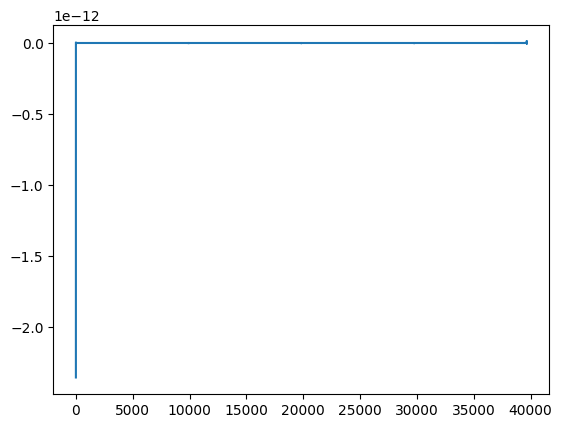

In [42]:
h_f= model(6.5, 0.2, 1, 2/9, 0, pi/3, freq) 
h=Freq_ifft(h_f)
print(np.imag(h))
plt.plot(np.real(h))

plt.show()

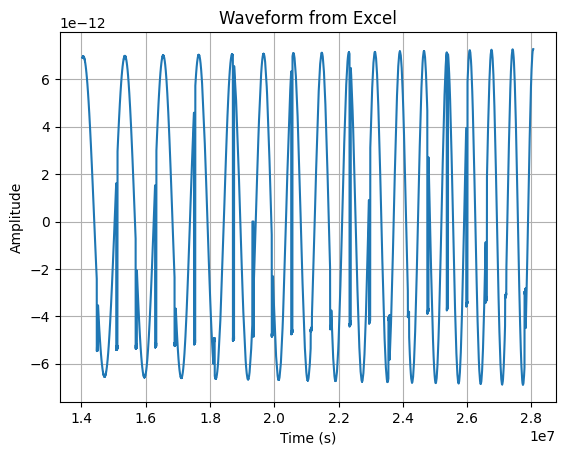

In [3]:
#从excel读入数据
import pandas as pd
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# 读取 Excel 文件
df = pd.read_excel("array1_data.xlsx")  # 可加 sheet_name="Sheet1" 参数

# 假设第1行为表头，B列是时间，C列是波形
time = df.iloc[:, 1].to_numpy()   # 第二列（B列）
waveform = df.iloc[:, 2].to_numpy()  # 第三列（C列）

# 绘图查看
plt.plot(time[10000:20000], waveform[10000:20000])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform from Excel")
plt.grid(True)
plt.show()


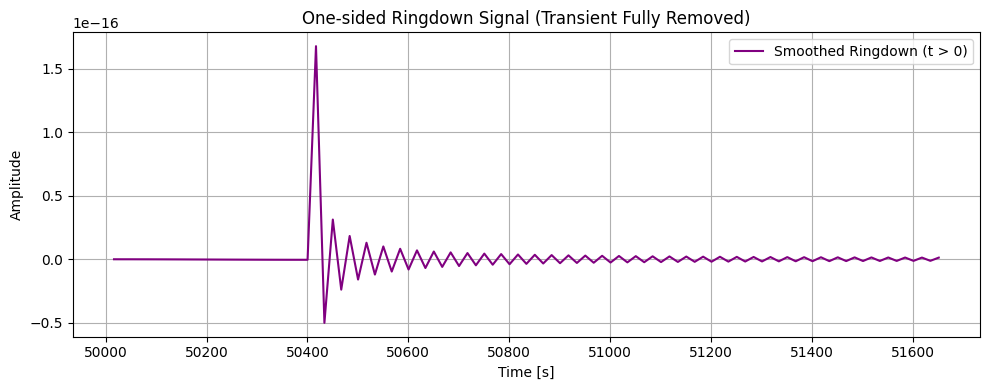

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

# Load data
f = np.loadtxt("f.txt")
h = np.loadtxt("h.txt", dtype=complex)

# Construct full spectrum (Hermitian symmetry)
h_neg = np.conj(h[1:-1][::-1])
h_full = np.concatenate([h, h_neg])

# Sampling parameters
N = len(h_full)
df = f[1] - f[0]
fs = df * N
dt = 1 / fs
time = np.arange(N) / fs

# Center the signal in time using frequency-domain phase shift
t0_shift = N / (2 * fs)
delay_phase = np.exp(-2j * np.pi * f * t0_shift)
h_shifted = h * delay_phase
h_neg_shifted = np.conj(h_shifted[1:-1][::-1])
h_full_shifted = np.concatenate([h_shifted, h_neg_shifted])
h_time_centered = np.fft.ifft(h_full_shifted).real

# Extract t > 0 part only to remove symmetry and transient
half_index = N // 2
h_post = h_time_centered[half_index:]
time_post = time[half_index:]

# High-pass FIR filter to smooth
cutoff = 1e-4  # Hz
numtaps = 51
fir_coeff = firwin(numtaps, cutoff, pass_zero=False, fs=fs)
h_post_smooth = lfilter(fir_coeff, [1.0], h_post)

# Save to file
final_data = np.column_stack((time_post, h_post_smooth))
np.savetxt("cleaned_ringdown_signal.txt", final_data, header="Time(s) Amplitude", fmt="%.10e")

# Plot result
plt.figure(figsize=(10, 4))
plt.plot(time_post[1:100], h_post_smooth[1:100], label='Smoothed Ringdown (t > 0)', color='purple')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("One-sided Ringdown Signal (Transient Fully Removed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ljq/miniconda3/envs/few_env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


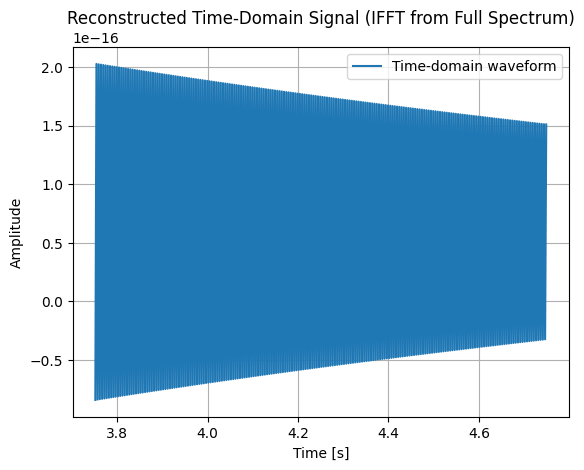

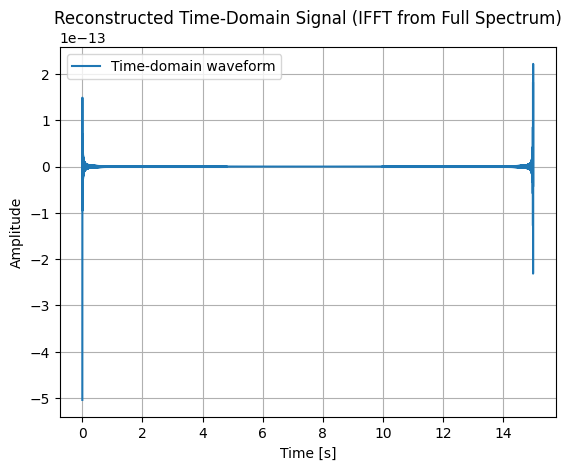

In [16]:
def Freq_ifft(h_f_1):
    Htilde = h_f_1
    n = len(h_f_1)
    N = n*2
    #构造用于ifft的频谱信号
    Htilde1 = [0]
    Htilde2 = Htilde[0:-1]*N/2
    Htilde3 = Htilde[-1]*N
    Htilde4 = np.conjugate(Htilde[0:-1])*N/2
    #将Htilde4数组反转，以使之对于中间点对称
    Htilde4 = Htilde4[::-1]

    #依次赋值每个数据点
    Htilde_pre = np.zeros(N,dtype=complex)
    for I in range(n-1):
        Htilde_pre[I+1] = Htilde2[I]
    Htilde_pre[n] = Htilde3
    for I in range(n-1):
        Htilde_pre[n+I+1] = Htilde4[I]

    #逆傅里叶变换
    htime = np.fft.ifft(Htilde_pre)

    #plt.plot(np.real(htime))
    #plt.plot(np.imag(htime))
    #plt.xscale('log')
   
    #plt.show()

    #plt.plot(np.abs(Htilde_pre))
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.show()
    return htime
df=1/15
f = np.loadtxt("f.txt")
h = np.loadtxt("h.txt", dtype=complex)
h_time= Freq_ifft(h)
time=np.linspace(0,1/df,len(h_time),endpoint=False)
# 画图
plt.plot(time[1500:1900], h_time[1500:1900], label='Time-domain waveform')
plt.xlabel("Time [s]") 
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.title("Reconstructed Time-Domain Signal (IFFT from Full Spectrum)")
plt.show()
plt.plot(time, h_time, label='Time-domain waveform')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.title("Reconstructed Time-Domain Signal (IFFT from Full Spectrum)")
plt.show()
# 画图

0.024841317866471233
174.67666800133233


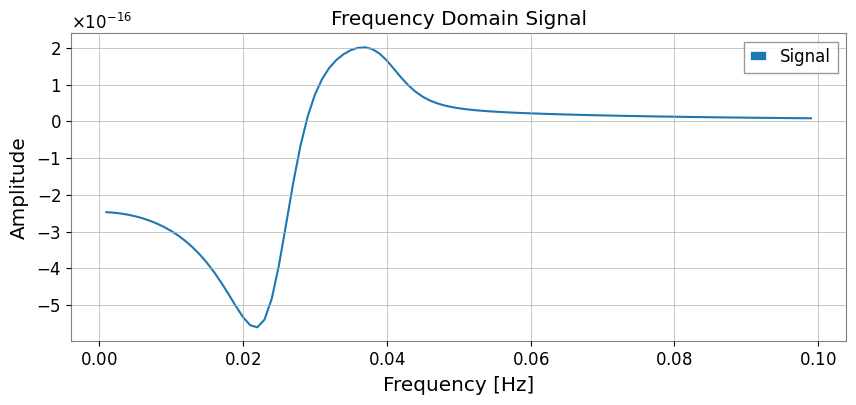

0.024697249851584852
177.7755471997847


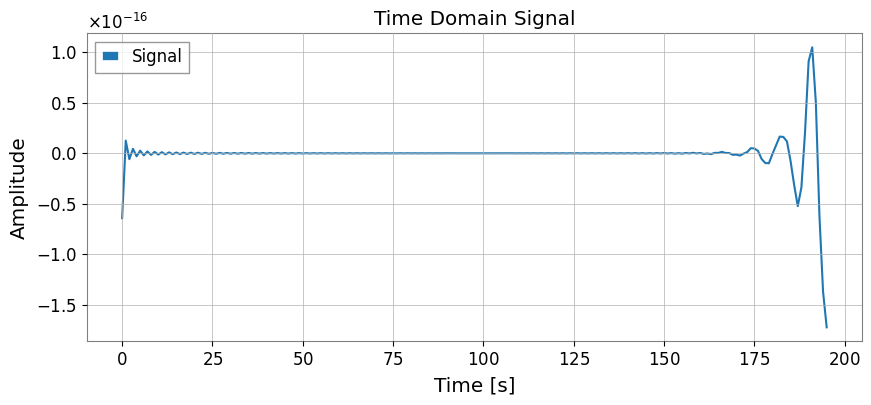

In [29]:
import sys
sys.path.append('/home/ljq/code/Ringdown_gap_filling/Proj')
import numpy as np
from waveform_GR.rd_wf2 import *    
freq=np.arange(0.001,0.1,0.001) 

h=model(6.5,0.1,0.5, 2/9, 0, pi/3, 0,freq)

print(w1(6.5,0,0.1))
print(tau1(6.5,0,0.1))
#绘制合理y轴范围的双对数图
plt.figure(figsize=(10, 4))
plt.plot(freq,np.real(h), label='Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('Frequency Domain Signal')
plt.legend()
plt.grid(True)
plt.show()
#傅里叶变换到时域
def Freq_ifft(h_f_1):
    """
    Perform real IFFT assuming h_f_1 is the one-sided spectrum (rfft output).
    Automatically infers N such that len(h_f_1) = N // 2 + 1
    """
    n_freq = len(h_f_1)
    N = 2 * (n_freq - 1)  # Recover time-domain length
    return np.fft.irfft(h_f_1, n=N)
h_time = Freq_ifft(h)
print(w22(6.5,0.1))
print(tau22(6.5,0.1))
#用loglog绘制频域信号
plt.figure(figsize=(10, 4))
plt.plot(np.real(h_time), label='Signal')
plt.xlabel('Time [s]') 
plt.ylabel('Amplitude')
plt.title('Time Domain Signal')
plt.legend()
plt.grid(True)
plt.show()